<a href="https://colab.research.google.com/github/vinyk/DA6401_Assignment1/blob/main/DA6401_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vinyk-sd (vinyk-sd-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


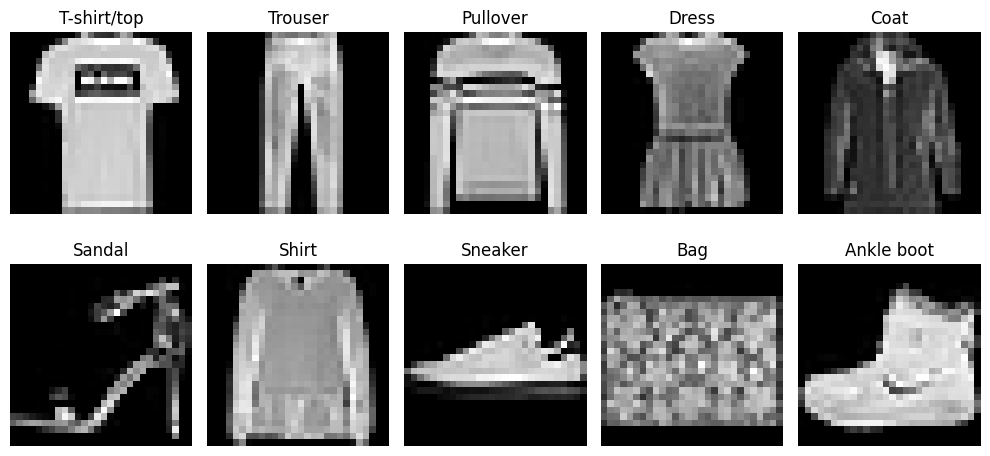

In [3]:
# Load Fashion-MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Class names for Fashion-MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Select one example per class
sample_images = []
sample_labels = []

for class_idx in range(10):
    idx = np.where(train_labels == class_idx)[0][0]  # Get the first occurrence of each class
    sample_images.append(train_images[idx])
    sample_labels.append(class_names[class_idx])

# Plot the images in a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(sample_images[i], cmap="gray")
    axes[i].set_title(sample_labels[i])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [27]:
import numpy as np

class FeedforwardNN:
    def __init__(self, input_size, hidden_layers, output_size,
                 optimizer="sgd", learning_rate=0.01, beta1=0.9, beta2=0.999,
                 epsilon=1e-8, weight_decay=0, weight_init="random", activation="relu"):
        """
        input_size: Number of input features
        hidden_layers: List of neurons in each hidden layer
        output_size: Number of output classes
        optimizer: Optimization algorithm to use ("sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam")
        learning_rate: Learning rate for optimization
        beta1, beta2: Momentum parameters (for Adam, Nadam, RMSprop, etc.)
        epsilon: Small value to avoid division by zero
        weight_decay: L2 regularization
        weight_init: Weight initialization ("random" or "xavier")
        activation: Activation function ("sigmoid", "tanh", "relu")
        """
        self.layers = [input_size] + hidden_layers + [output_size]
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.optimizer = optimizer
        self.weight_decay = weight_decay
        self.activation = activation

        # Initialize weights and biases
        self.weights = {}
        self.biases = {}
        self.velocities = {}  # For momentum/NAG
        self.squared_grads = {}  # For RMSprop/Adam
        self.momentum_cache = {}  # For Adam/Nadam

        for i in range(len(self.layers) - 1):
            if weight_init == "xavier":
                # Xavier initialization (for ReLU)
                self.weights[i] = np.random.randn(self.layers[i], self.layers[i + 1]) * np.sqrt(2 / (self.layers[i] + self.layers[i + 1]))
            else:
                # Random initialization (scaled)
                self.weights[i] = np.random.randn(self.layers[i], self.layers[i + 1]) * 0.01

            self.biases[i] = np.zeros((1, self.layers[i + 1]))

            # Initialize optimizer-specific parameters
            self.velocities[i] = np.zeros_like(self.weights[i])  # Momentum
            self.squared_grads[i] = np.zeros_like(self.weights[i])  # RMSprop, Adam
            self.momentum_cache[i] = np.zeros_like(self.weights[i])  # Adam, Nadam

    def activation_function(self, x):
        if self.activation == "sigmoid":
            return 1 / (1 + np.exp(-x))
        elif self.activation == "tanh":
            return np.tanh(x)
        else:  # Default to ReLU
            return np.maximum(0, x)

    def activation_derivative(self, x):
        if self.activation == "sigmoid":
            return self.activation_function(x) * (1 - self.activation_function(x))
        elif self.activation == "tanh":
            return 1 - np.tanh(x) ** 2
        else:  # Default to ReLU
            return (x > 0).astype(float)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Prevent overflow
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        activations = {0: X}  # Store activations
        for i in range(len(self.layers) - 2):
            Z = np.dot(activations[i], self.weights[i]) + self.biases[i]
            activations[i + 1] = self.activation_function(Z)

        # Output layer (softmax)
        Z_out = np.dot(activations[len(self.layers) - 2], self.weights[len(self.layers) - 2]) + self.biases[len(self.layers) - 2]
        activations[len(self.layers) - 1] = self.softmax(Z_out)

        return activations

    def backward(self, X, Y, activations, batch_size, t):
      grads = {}
      L = len(self.layers) - 1  # Number of layers
      m = X.shape[0]  # Batch size

      # One-hot encode labels
      Y_one_hot = np.eye(self.layers[-1])[Y]  # Shape (batch_size, num_classes)

      # Compute softmax gradient for the output layer (L-th layer)
      dZ = activations[L] - Y_one_hot  # Gradient for output layer
      grads[L] = dZ  # Store gradient for the output layer

      # Backpropagate through hidden layers
      for i in reversed(range(L)):  # Loop through layers from L-1 to 0
          # Compute gradients for weights and biases
          if i == 0:
              # For the first layer, activations[i] is the input data X
              dW = np.dot(X.T, grads[i + 1]) / m + self.weight_decay * self.weights[i]  # L2 regularization
          else:
              dW = np.dot(activations[i].T, grads[i + 1]) / m + self.weight_decay * self.weights[i]  # L2 regularization
          db = np.sum(grads[i + 1], axis=0, keepdims=True) / m

          # Backpropagate the gradient to the previous layer
          if i != L - 1:
              grads[i] = np.dot(grads[i + 1], self.weights[i + 1].T) * self.activation_derivative(activations[i])

          # Update weights and biases using the optimizer
          self.update_weights(i, dW, db, t)


    def update_weights(self, i, dW, db, t):
        """
        Update weights and biases using the chosen optimizer.
        """
        if self.optimizer == "sgd":
            self.weights[i] -= self.learning_rate * dW
            self.biases[i] -= self.learning_rate * db

        elif self.optimizer == "momentum":
            self.velocities[i] = self.beta1 * self.velocities[i] + (1 - self.beta1) * dW
            self.weights[i] -= self.learning_rate * self.velocities[i]
            self.biases[i] -= self.learning_rate * db

        elif self.optimizer == "nesterov":
            prev_v = self.velocities[i]
            self.velocities[i] = self.beta1 * self.velocities[i] + (1 - self.beta1) * dW
            self.weights[i] -= self.learning_rate * (self.beta1 * prev_v + (1 - self.beta1) * self.velocities[i])
            self.biases[i] -= self.learning_rate * db

        elif self.optimizer == "rmsprop":
            self.squared_grads[i] = self.beta2 * self.squared_grads[i] + (1 - self.beta2) * (dW ** 2)
            self.weights[i] -= self.learning_rate * dW / (np.sqrt(self.squared_grads[i]) + self.epsilon)
            self.biases[i] -= self.learning_rate * db

        elif self.optimizer == "adam":
            self.momentum_cache[i] = self.beta1 * self.momentum_cache[i] + (1 - self.beta1) * dW
            self.squared_grads[i] = self.beta2 * self.squared_grads[i] + (1 - self.beta2) * (dW ** 2)

            m_hat = self.momentum_cache[i] / (1 - self.beta1 ** t)
            v_hat = self.squared_grads[i] / (1 - self.beta2 ** t)

            self.weights[i] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
            self.biases[i] -= self.learning_rate * db

        elif self.optimizer == "nadam":
            m_hat = (self.beta1 * self.momentum_cache[i] + (1 - self.beta1) * dW) / (1 - self.beta1 ** t)
            v_hat = self.squared_grads[i] / (1 - self.beta2 ** t)

            self.weights[i] -= self.learning_rate * (self.beta1 * m_hat + (1 - self.beta1) * dW) / (np.sqrt(v_hat) + self.epsilon)
            self.biases[i] -= self.learning_rate * db

    def compute_loss(self, Y_true, Y_pred):
        m = Y_true.shape[0]
        Y_one_hot = np.eye(self.layers[-1])[Y_true]
        loss = -np.sum(Y_one_hot * np.log(Y_pred + 1e-9)) / m
        return loss

    def train(self, X_train, Y_train, epochs, batch_size):
        for epoch in range(epochs):
            for batch_start in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[batch_start: batch_start + batch_size]
                Y_batch = Y_train[batch_start: batch_start + batch_size]

                activations = self.forward(X_batch)
                self.backward(X_batch, Y_batch, activations, batch_size, epoch + 1)

            loss = self.compute_loss(Y_train, self.forward(X_train)[len(self.layers) - 1])
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")


In [6]:
sweep_config = {
    "method": "bayes",  # Bayesian search for efficiency (can also use "grid" or "random")
    "metric": {"name": "val_accuracy", "goal": "maximize"},
    "parameters": {
        "epochs": {"values": [5, 10]},
        "num_hidden_layers": {"values": [3, 4, 5]},
        "hidden_layer_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "weight_initialization": {"values": ["random", "xavier"]},
        "activation_function": {"values": ["sigmoid", "tanh", "relu"]},
    },
}

In [7]:
# Load dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize and flatten images
X_train = (X_train / 255.0).reshape(X_train.shape[0], -1)
X_test = (X_test / 255.0).reshape(X_test.shape[0], -1)

# Split training data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [28]:
def train_model(config=None):
    with wandb.init(config=config):
        config = wandb.config  # Access hyperparameters

        # Initialize model
        model = FeedforwardNN(
            input_size=28*28,
            hidden_layers=[config.hidden_layer_size] * config.num_hidden_layers,
            output_size=10,
            activation=config.activation_function,
            weight_init=config.weight_initialization,
            weight_decay=config.weight_decay,
            optimizer=config.optimizer,
            learning_rate=config.learning_rate
        )

        # Training loop
        for epoch in range(config.epochs):
            loss, accuracy = model.train(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size)
            val_loss, val_accuracy = model.evaluate(X_val, y_val)

            # Log metrics to wandb
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": loss,
                "train_accuracy": accuracy,
                "val_loss": val_loss,
                "val_accuracy": val_accuracy
            })

        # Final evaluation on test set
        test_loss, test_accuracy = model.evaluate(X_test, y_test)
        wandb.log({"test_loss": test_loss, "test_accuracy": test_accuracy})


In [29]:
sweep_id = wandb.sweep(sweep_config, project="fashion-mnist-hyperparameter-tuning")
wandb.agent(sweep_id, train_model, count=20)  # Run 20 trials with different hyperparameters

Create sweep with ID: w8eg7ykb
Sweep URL: https://wandb.ai/vinyk-sd-indian-institute-of-technology-madras/fashion-mnist-hyperparameter-tuning/sweeps/w8eg7ykb


wandb: Agent Starting Run: 90rp36xj with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialization: xavier


Traceback (most recent call last):
  File "<ipython-input-28-d67e6f89803e>", line 19, in train_model
    loss, accuracy = model.train(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-27-1641fe8015a0>", line 166, in train
    self.backward(X_batch, Y_batch, activations, batch_size, epoch + 1)
  File "<ipython-input-27-1641fe8015a0>", line 101, in backward
    dW = np.dot(activations[i].T, grads[i + 1]) / m + self.weight_decay * self.weights[i]  # L2 regularization
                                  ~~~~~^^^^^^^
KeyError: 4


Run 90rp36xj errored:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "<ipython-input-28-d67e6f89803e>", line 19, in train_model
    loss, accuracy = model.train(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-27-1641fe8015a0>", line 166, in train
    self.backward(X_batch, Y_batch, activations, batch_size, epoch + 1)
  File "<ipython-input-27-1641fe8015a0>", line 101, in backward
    dW = np.dot(activations[i].T, grads[i + 1]) / m + self.weight_decay * self.weights[i]  # L2 regularization
                                  ~~~~~^^^^^^^
KeyError: 4

wandb: ERROR Run 90rp36xj errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _ru

Traceback (most recent call last):
  File "<ipython-input-28-d67e6f89803e>", line 19, in train_model
    loss, accuracy = model.train(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-27-1641fe8015a0>", line 166, in train
    self.backward(X_batch, Y_batch, activations, batch_size, epoch + 1)
  File "<ipython-input-27-1641fe8015a0>", line 101, in backward
    dW = np.dot(activations[i].T, grads[i + 1]) / m + self.weight_decay * self.weights[i]  # L2 regularization
                                  ~~~~~^^^^^^^
KeyError: 4


wandb: Ctrl + C detected. Stopping sweep.
